In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Value:

    def __init__(self, data, _children=(), _op='', label = '') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value({self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int or float"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other): # self / other
        return self * other ** -1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        tanh_formula = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(tanh_formula, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - tanh_formula ** 2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def topo_sort(v): # topological sort
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topo_sort(child)
                topo.append(v)
        topo_sort(self)   

        self.grad = 1.0 
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = c + e; d.label = 'd' 
f = Value(-2.0, label='f')
L = d * f; L.label = 'L' 

a / b

Value(-0.6666666666666666)

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [5]:
# single neuron

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

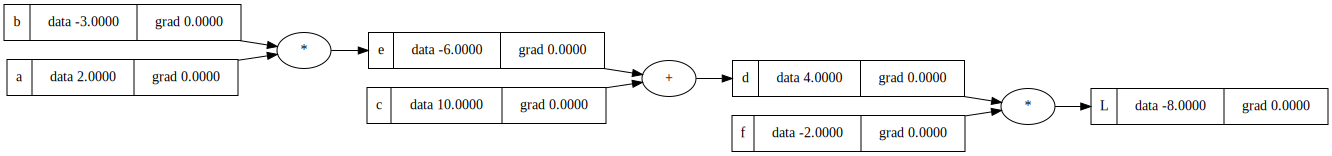

In [6]:
draw_dot(L)

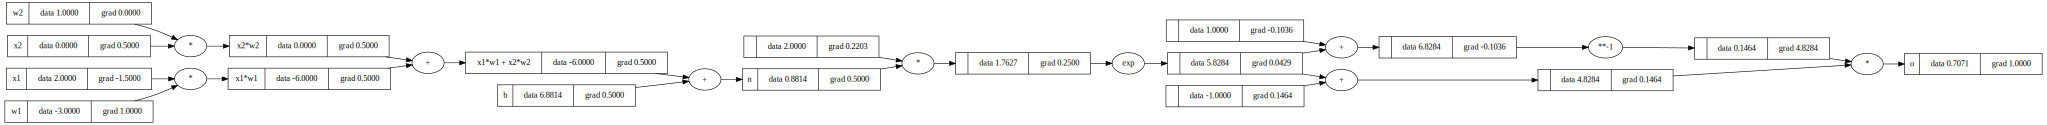

In [7]:
# single neuron

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# ----------------------------
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [8]:
import torch

In [9]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [10]:
class Neuron:
    def __init__(self, nin): # nin = number of inputs
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)] # weights
        self.b = Value(np.random.uniform(-1, 1)) # bias

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout): # nout = number of neurons in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

class MLP:
    def __init__(self, nin, nouts): # nouts = number of neurons in each layer
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            # print(f"layer: {x}")
            x = layer(x)
        return x

    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]




In [15]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [8, 8, 1])
n(x)
len(n.parameters())

113

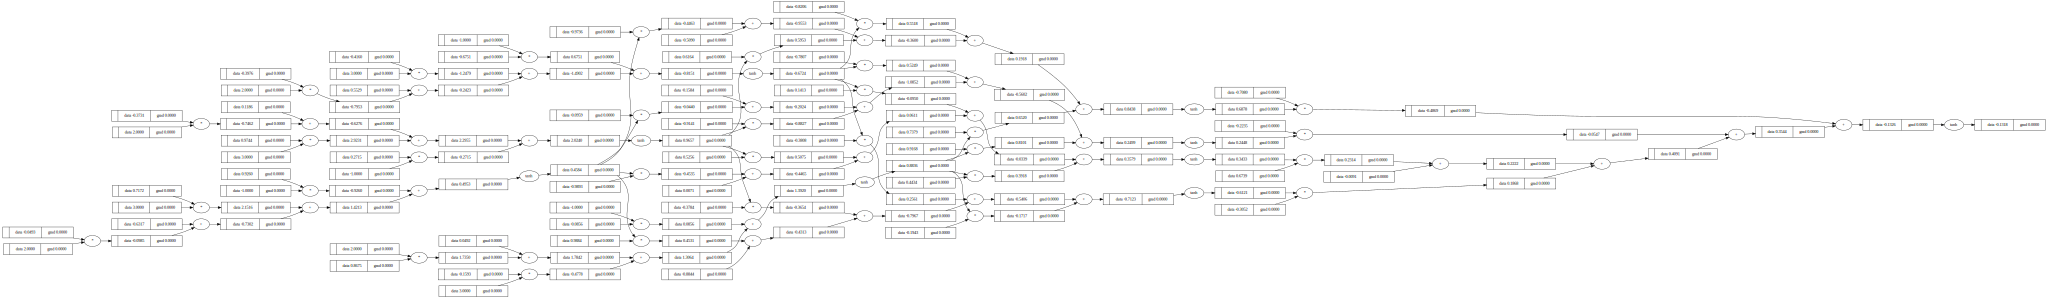

In [12]:
draw_dot(n(x))

In [13]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [23]:
n = MLP(3, [4, 4, 1])
for k in range(100):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - yt)**2 for yt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update / fine-tune params
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)  

ypred

[Value(0.2971119401160949), Value(0.29914106392346), Value(0.526479835320039), Value(0.3064443221247386)]
[Value(0.12702966182336053), Value(0.03547081295357249), Value(0.25541220312426305), Value(0.13101280083653763)]
[Value(0.15017416419795485), Value(-0.013402773182786413), Value(0.07521806514281872), Value(0.12056205578655742)]
[Value(0.25805441222120995), Value(-0.04404618497417136), Value(-0.08152801546095509), Value(0.15958418949347702)]
[Value(0.4082560171003672), Value(-0.1124523172405743), Value(-0.2366113654038484), Value(0.22904127383356873)]
[Value(0.5304452249374993), Value(-0.22963043168393882), Value(-0.3899757522853286), Value(0.30410854209468585)]
[Value(0.6339426450951445), Value(-0.35068417347700076), Value(-0.5092510558424911), Value(0.3970193404248102)]
[Value(0.7111933407618356), Value(-0.46023904503799723), Value(-0.6017849382889322), Value(0.48474513655799073)]
[Value(0.7668305831976716), Value(-0.5471079399020762), Value(-0.6704539406444662), Value(0.559424427

[Value(0.9769636391958538),
 Value(-0.9526141402470285),
 Value(-0.9672697719554886),
 Value(0.9472231929682823)]